### Handling bd CPS observations whose hours vary

Brian Dew<br>
September 28, 2019

----

Starting in 1994, CPS respondents could report that their usual hours vary. Because the bd CPS derives hourly wages for nonhourly workers from usual weekly earnings divided by usual weekly hours, the extracts' hourly wage series has holes where nonhourly workers usual hours vary.


Replacing the missing usual hours variable with actual hours would inflate hourly wages for individuals with paid absenses from work or who are paid for full-time work but worked part-time. Likewise, observations that worked more hours than usual would have artificially low hourly wage estimates. 


When at CEPR, John Schmitt handled the hours vary problem by imputing usual hours for workers who are not paid hourly but whose hours vary. The CEPR imputation comes from the results of four regressions that seek to explain usual hours of workers who report usual hours based on age, education, race, marital status, nativity, and citizenship. The four regressions correspond to four groups (men or women and usually full-time or usually part-time).

Here's an example:

```
		/* FT, women */
reg pehrusl1 age `agesq' `white' `black' `hisp' /*
*/ `lths' `hs' `col' `adv' married forborn citizen /*
*/ if empl==1 & selfemp==0 & hrsvary==0 & /*
*/ (3<=prhrusl & prhrusl<=6) & female==1
predict imphr1 if female==1 & prhrusl==7 /* varies, FT */

```

Then, the CEPR program creates a new variable, `uhoursi` that is equal to usual hours when hours don't vary, "hours paid at this rate" when hours vary and paid hourly, and the regression prediction when hours vary and not paid hourly.  


Before deciding how to approach the "hours vary" problem, I want to look at some summary statistics and lay out some options. 


#### Options include:

- CEPR approach verbatim
- CEPR approach different regressions
- Use actual hours
- Calculate usual hours for 7-8x matched observations
- Calculate usual hours for 3x+ matched observations
- Fill in only those whose actual hours aren't typical


Beyond basic summary statistics, perhaps there is some additional information in longitudinally matched data. For some (probably small) portion of fully-matched people, I'll be able to find 8 observations that all report "hours vary" and all have the same industry and occupation code, about the same weekly pay, and all report actual hours. For that group I can see how much actual hours vary when measured 8 times. 


Separately, one simple option is to use the CEPR regressions but also add 11 month binary variables to address seasonality in hours vary data. 

In [18]:
%matplotlib inline

import pandas as pd
import numpy as np 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os, itertools
os.environ['X13PATH'] = '/home/brian/Documents/econ_data/micro/x13as/'
from statsmodels.tsa.x13 import (_find_x12, x13_arima_select_order,
                                 x13_arima_analysis)


cps_dir = '/home/brian/Documents/CPS/data/clean/'

# Create new variables
hrsvary = lambda x: np.where(x['HRSUSL1'] == -4, 1, 0)
agesq = lambda x: x['AGE'].astype('int')**2
private = lambda x: np.where(x['COW1'] == 'Private', 1, 0)
act50 = lambda x: np.where(x['HRSACT1'] > 50, 1, 0)
act40 = lambda x: np.where(x['HRSACT1'] == 40, 1, 0)
act16 = lambda x: np.where((x['HRSACT1'] <= 16) & (x['HRSACT1'] >=0), 1, 0)


selfemp = ['Self-employed Incorporated', 'Self-employed Unincorporated']
gender = [0, 1]
ftpt = [([1, 2], 8), ([3, 4, 5, 6], 7)]


# Refression formula
spec = '''HRSUSL1 ~ AGE + AGESQ + C(WBHAO) + C(EDUC) + C(INDGRP) + MARRIED + 
          FORBORN + NCHILDU5 + ACT50 + ACT40 + ACT16 + PRIVATE'''

In [2]:
# Seasonally adjusted trend
cols = ['YEAR', 'MONTH', 'HRSUSL1', 'PWSSWGT', 'FEMALE']

d = pd.DataFrame()

for year in range(1994, 2020):
    s = (pd.read_feather(f'{cps_dir}cps{year}.ft', columns=cols)
           .query('HRSUSL1 != -1')
           .assign(HRSVARY = hrsvary))
    
    for name, i in [('Men', 0), ('Women', 1)]:
        t = (s.query('FEMALE == @i')
              .groupby(['MONTH'])
              .apply(lambda x: np.average(x.HRSVARY, weights=x.PWSSWGT)))
        t.index = [pd.to_datetime(f'{year}-{i}-01') for i in t.index]
    
        for month in t.index:
            d.at[month, name] = t[month]

/home/brian/miniconda3/lib/python3.7/site-packages/statsmodels/tsa/x13.py:187: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)


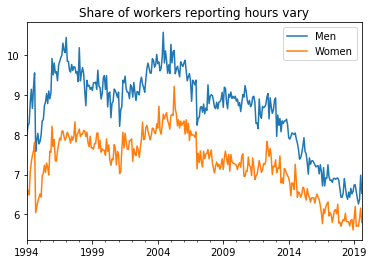

In [3]:
ax = pd.concat([x13_arima_analysis(d[g].multiply(100)).seasadj 
                for g in d.keys()], axis=1).plot(
    title='Share of workers reporting hours vary')
ax.legend(d.keys());

In [21]:
cols = ['MONTH', 'HRSUSL1', 'PWSSWGT', 'AGE', 'FEMALE', 
        'WBHAO', 'EDUC', 'NCHILDU5', 'HRSACT1', 'COW1',
        'PEHRFTPT', 'PAIDHRLY', 'PEERNPER', 'PEERNHRO', 
        'PRHRUSL', 'INDGRP', 'MARRIED', 'FORBORN',
        'RWKWAGE', 'RHRWAGE', 'PROXY', 'MIS', 'LFS', 
        'WORKFT']

# Latest value
df = (pd.read_feather(f'{cps_dir}cps2019.ft', columns=cols)
        .query('HRSUSL1 != -1 and MONTH == 8')
        .assign(HRSVARY = hrsvary,
                AGESQ = agesq,
                PRIVATE = private,
                ACT50 = act50,
                ACT40 = act40, 
                ACT16 = act16)
        .astype({'MARRIED': int, 'FORBORN': int}))

for i in itertools.product(gender, ftpt):
    
    data = df.query('FEMALE == @i[0] and PRHRUSL in @i[1][0] and COW1 not in @selfemp')
    mod = smf.ols(formula=spec, data=data)
    res = mod.fit()
    
    loci = ((df['FEMALE'] == i[0]) & 
    (df['PRHRUSL'].isin(i[1][0]) | (df['PRHRUSL'] == i[1][1])))
    
    d = df[loci]
    
    df.loc[loci, 'HRSUSL1I'] = (np.where(d['HRSUSL1'] != -4, d['HRSUSL1'], 
                                np.where(d['PEERNHRO'] > 0, d['PEERNHRO'],
                                         res.predict(d))))

In [27]:
df[['HRSUSL1', 'HRSUSL1I']].mean()

HRSUSL1     36.142678
HRSUSL1I    39.012451
dtype: float64

In [31]:
print(df.query('HRSUSL1 > 0').HRSUSL1.mean())
print(df.query('HRSUSL1I > 0').HRSUSL1I.mean())

39.13130613772455
39.04236691258202


In [32]:
print(df.query('HRSUSL1 == -4').HRSUSL1I.mean())

37.835737770257374


In [21]:
(np.where(data['HRSUSL1'] != -4, data['HRSUSL1'], 
 np.where(data['PEERNHRO'] > 0, data['PEERNHRO'],
          res.predict(data))))

array([40., 42., 40., ..., 35., 35., 40.])

In [17]:
df.

,MONTH,HRSUSL1,PEHRFTPT,HRSACT1,PRHRUSL,PEERNPER,PEERNHRO,PWSSWGT,AGE,FEMALE,...,INDGRP,PAIDHRLY,COW1,NCHILDU5,HRSVARY,AGESQ,PRIVATE,ACT50,ACT40,ACT16
235815,8,40,-1,-1,4,6,-1,1696.787598,63,1,...,Manufacturing,0.0,Private,0,0,3969,1,0,0,0
235818,8,42,-1,35,5,6,-1,1922.988037,51,1,...,Public administration,0.0,State Government,0,0,2601,0,0,0,0
235830,8,40,-1,40,4,1,40,2140.696289,35,1,...,Education and health,1.0,Private,0,0,1225,1,0,1,0
235833,8,40,-1,40,4,-1,-1,1821.840942,59,1,...,Finance and business services,NaN,Private,0,0,3481,1,0,1,0
235836,8,55,-1,55,6,-1,-1,2241.842285,56,1,...,Education and health,NaN,Self-employed Unincorporated,0,0,3136,0,1,0,0
235840,8,40,-1,40,4,-1,-1,1912.364014,29,1,...,Education and health,NaN,Private,1,0,841,1,0,1,0
235844,8,40,-1,40,4,-1,-1,1843.742432,25,1,...,Finance and business services,NaN,Private,0,0,625,1,0,1,0
235846,8,40,-1,40,4,-1,-1,1933.911987,58,1,...,Finance and business services,NaN,Private,0,0,3364,1,0,1,0
235848,8,40,-1,40,4,-1,-1,3531.765137,29,1,...,Finance and business services,NaN,Private,0,0,841,1,0,1,0
235854,8,36,-1,36,3,-1,-1,2595.000488,34,1,...,Education and health,NaN,Self-employed Unincorporated,0,0,1156,0,0,0,0


In [7]:
for i in itertools.product(gender, ftpt):
    print(i)

(0, [1, 2])
(0, [3, 4, 5, 6])
(1, [1, 2])
(1, [3, 4, 5, 6])


In [ ]:
agesq = lambda x: x['AGE'].astype('int')**2
private = lambda x: np.where(x['COW1'] == 'Private', 1, 0)
act50 = lambda x: np.where(x['HRSACT1'] > 50, 1, 0)
act40 = lambda x: np.where(x['HRSACT1'] == 40, 1, 0)
act16 = lambda x: np.where((x['HRSACT1'] <= 16) & (x['HRSACT1'] >=0), 1, 0)

In [14]:
df.loc[:, 'AGESQ'] = df['AGE'].astype('int')**2
df.loc[:, ['MARRIED', 'FORBORN']] = df[['MARRIED', 'FORBORN']].astype(int)
df.loc[:, 'PRIVATE'] = np.where(df['COW1'] == 'Private', 1, 0)
df.loc[:, 'ACT50'] = np.where(df['HRSACT1'] > 50, 1, 0)
df.loc[:, 'ACT40'] = np.where(df['HRSACT1'] == 40, 1, 0)
df.loc[:, 'ACT16'] = np.where((df['HRSACT1'] <= 16) & (df['HRSACT1'] >=0), 1, 0)

In [ ]:
data['AGESQ'] = data['AGE'].astype('int')**2
data[['MARRIED', 'FORBORN']] = data[['MARRIED', 'FORBORN']].astype(int)
data['PRIVATE'] = np.where(data['COW1'] == 'Private', 1, 0)
data['ACT50'] = np.where(data['HRSACT1'] > 50, 1, 0)
data['ACT40'] = np.where(data['HRSACT1'] == 40, 1, 0)
data['ACT16'] = np.where((data['HRSACT1'] <= 16) & (data['HRSACT1'] >=0), 1, 0)

spec = '''HRSUSL1 ~ AGE + AGESQ + C(WBHAO) + C(EDUC) + C(INDGRP) + MARRIED + 
          FORBORN + NCHILDU5 + ACT50 + ACT40 + ACT16 + PRIVATE'''

mod = smf.ols(formula=spec, data=data)

res = mod.fit()


data['HRSUSL1I'] = (np.where(data['HRSUSL1'] != -4, data['HRSUSL1'], 
                    np.where(data['PEERNHRO'] > 0, data['PEERNHRO'],
                             res.predict(data))))

#print(res.summary())

In [27]:
df.groupby(['HRSVARY', 'PEHRFTPT']).HRSACT1.mean()

HRSVARY  PEHRFTPT
0        -1          36.844387
          1          37.171103
          2          17.080000
1         1          38.202997
          2          17.168495
Name: HRSACT1, dtype: float64

In [29]:
df.groupby(['HRSVARY', 'PEHRFTPT']).HRSUSL1I.mean()

HRSVARY  PEHRFTPT
0        -1          39.101173
          1          40.821293
          2          16.600000
1         1                NaN
          2                NaN
Name: HRSUSL1I, dtype: float64

In [ ]:
data

In [ ]:
mod = smf.ols(formula=spec, data=data)

res = mod.fit()

print(res.summary())

In [ ]:
spec = '''HRSUSL1 ~ AGE + AGESQ + C(WBHAO) + C(EDUC) + C(INDGRP) + MARRIED + 
          FORBORN + NCHILDU5 + ACT50 + ACT40 + ACT16 + PRIVATE'''

In [ ]:
cols = ['MONTH', 'HRSUSL1', 'PWSSWGT', 'AGE', 'FEMALE', 
        'WBHAO', 'EDUC', 'NCHILDU5', 'HRSACT1', 'WORKFT', 
        'PEHRFTPT', 'WORKFT', 'PAIDHRLY', 'PROXY', 'RHRWAGE',
        'RWKWAGE', 'MIS', 'LFS', 'PEERNPER', 'PEERNHRO', 
        'PRHRUSL', 'INDGRP', 'MARRIED', 'FORBORN', 
        'REGION', 'METSTA', 'COW1']

# Latest value
df = (pd.read_feather(f'{cps_dir}cps2019.ft', columns=cols)
        .query('HRSUSL1 != -1 and MONTH == 8')
        .assign(HRSVARY = hrsvary))

hrusl = [3, 4, 5, 6]

selfemp = ['Self-employed Incorporated', 'Self-employed Unincorporated']

data = df.query('FEMALE == 0 and PRHRUSL in @hrusl and COW1 not in @selfemp') # [3, 4, 5, 6]

data['AGESQ'] = data['AGE'].astype('int')**2
data[['MARRIED', 'FORBORN']] = data[['MARRIED', 'FORBORN']].astype(int)
data['PRIVATE'] = np.where(data['COW1'] == 'Private', 1, 0)
data['ACT50'] = np.where(data['HRSACT1'] > 50, 1, 0)
data['ACT40'] = np.where(data['HRSACT1'] == 40, 1, 0)
data['ACT16'] = np.where((data['HRSACT1'] <= 16) & (data['HRSACT1'] >=0), 1, 0)

In [ ]:
len(df.query('HRSVARY == 1'))

In [ ]:
df.groupby('HRSVARY').PWSSWGT.sum().divide(1000).round(0)

In [ ]:
df.groupby(['HRSVARY', 'FEMALE', 'WBHAO', 'EDUC']).PWSSWGT.sum().divide(12000).round(0)

In [ ]:
df.groupby(['FEMALE', 'WBHAO']).HRSVARY.mean()

In [ ]:
df.groupby(['FEMALE', 'EDUC']).HRSVARY.mean()

In [ ]:
df.groupby(['FEMALE', 'EDUC', 'HRSVARY']).PWSSWGT.sum().divide(1000).round(0)

In [ ]:
df.groupby(['FEMALE', 'EDUC', 'HRSVARY']).HRSACT1.mean()

In [ ]:
df.groupby(['HRSVARY', 'PEHRFTPT']).HRSACT1.mean()

In [ ]:
srs = ['PEHRFTPT', 'HRSUSL1', 'HRSACT1', 'WORKFT', 'PAIDHRLY',
       'PROXY', 'RHRWAGE', 'RWKWAGE', 'MIS', 'LFS', 'PEERNPER', 
       'PEERNHRO', 'PRHRUSL', 'METSTA']

df[srs].query('MIS in [4, 8] and RWKWAGE > 0 ').tail()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
selfemp = ['Self-employed Incorporated', 'Self-employed Unincorporated']

data = df.query('FEMALE == 0 and PRHRUSL in [3, 4, 5, 6] and COW1 not in @selfemp') # [3, 4, 5, 6]

data['AGESQ'] = data['AGE'].astype('int')**2
data[['MARRIED', 'FORBORN']] = data[['MARRIED', 'FORBORN']].astype(int)
data['PRIVATE'] = np.where(data['COW1'] == 'Private', 1, 0)
data['WINTER'] = np.where(data['MONTH'].isin([1, 2, 12]), 1, 0)
data['ACT50'] = np.where(data['HRSACT1'] > 50, 1, 0)
data['ACT40'] = np.where(data['HRSACT1'] == 40, 1, 0)
data['ACT16'] = np.where((data['HRSACT1'] <= 16) & (data['HRSACT1'] >=0), 1, 0)

In [ ]:
mod = smf.ols(formula='HRSUSL1 ~ AGE + AGESQ + C(WBHAO) + C(EDUC) + C(INDGRP) + MARRIED + FORBORN + NCHILDU5 + ACT50 + ACT40 + ACT16 + PRIVATE', data=data)

res = mod.fit()

print(res.summary())

In [ ]:
selfemp = ['Self-employed Incorporated', 'Self-employed Unincorporated']

data = df.query('FEMALE == 0 and PRHRUSL == 7 and COW1 not in @selfemp') # [3, 4, 5, 6]

data['AGESQ'] = data['AGE'].astype('int')**2
data[['MARRIED', 'FORBORN']] = data[['MARRIED', 'FORBORN']].astype(int)
data['PRIVATE'] = np.where(data['COW1'] == 'Private', 1, 0)
data['WINTER'] = np.where(data['MONTH'].isin([1, 2, 12]), 1, 0)
data['ACT50'] = np.where(data['HRSACT1'] > 50, 1, 0)
data['ACT40'] = np.where(data['HRSACT1'] == 40, 1, 0)
data['ACT16'] = np.where((data['HRSACT1'] <= 16) & (data['HRSACT1'] >=0), 1, 0)


data['USLHRS1I'] = res.predict(data)

In [ ]:
data